In [1]:
import os
import csv
import time
import datetime
import random
import json

import warnings
from collections import Counter
from math import sqrt

import gensim
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch

# Model

In [2]:
from torch import nn, Tensor
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn_temp = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.fc = nn.Linear(embedding_dim, embedding_dim)
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    #for A
    #x, (hidden_n, _) = self.rnn_temp(x)
    #x, (hidden_n, _) = self.rnn_temp(x)
    
    x, (hidden_n, _) = self.rnn2(x)
    #forA
    #x =  nn.functional.leaky_relu(self.fc(x), negative_slope=0.01, inplace=False)

    return hidden_n.reshape((self.n_features, self.embedding_dim))


class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.fc = nn.Linear(input_dim, input_dim)
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    #forA
    #x =  nn.functional.leaky_relu(self.fc(x), negative_slope=0.01, inplace=False)

    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    #forA
    #x, (hidden_n, cell_n) = self.rnn1(x)
    #x, (hidden_n, cell_n) = self.rnn1(x)
    
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [4]:
def split_list(l, n):
  for idx in range(0, len(l), n):
    yield l[idx:idx+n]

In [5]:
from torch import nn, Tensor
class C_Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(C_Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.enc1 = nn.Conv1d(in_channels= 1, out_channels =32, kernel_size=7, padding=3, stride=2)
    self.dropout = nn.Dropout(0.2)
    self.enc2 = nn.Conv1d(in_channels= 32,out_channels =16, kernel_size=7, padding=3, stride=2)
    self.fc = nn.Linear(embedding_dim, embedding_dim)
  def forward(self, x):
    x = x.reshape((1, self.n_features, self.seq_len))
    x = self.enc1(x)
    #print('after e1', x.size())
    x = self.dropout(x)
    x = self.enc2(x)
    #print('after e2', x.size())
    
    return x#hidden_n.reshape((self.n_features, self.embedding_dim))


class C_Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(C_Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.fc = nn.Linear(input_dim, input_dim)
    self.dec1 = nn.ConvTranspose1d(in_channels= 16,out_channels =16, kernel_size=6, padding=2, stride=2)
    self.dec2 = nn.ConvTranspose1d(in_channels= 16,out_channels =32, kernel_size=6, padding=2, stride=2)
    self.dec3 = nn.ConvTranspose1d(in_channels= 32,out_channels =1, kernel_size=5, padding=2)
    self.dropout = nn.Dropout(0.2)
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    #forA
    #x =  nn.functional.leaky_relu(self.fc(x), negative_slope=0.01, inplace=False)

    #x = x.repeat(self.seq_len, self.n_features)
    #x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x = self.dec1(x)
    #print('after d1', x.size())
    x = self.dropout(x)
    x = self.dec2(x)
    #print('after d2', x.size())
    x = self.dec3(x)
    #print('after d3', x.size())
    return x#self.output_layer(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Autoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Autoencoder, self).__init__()
    self.seq_len = seq_len
    self.n_features = n_features
    self.encoder = C_Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = C_Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    #print('after encoder', x.size())
    x = self.decoder(x)
    return x.reshape((self.seq_len))

# Train

In [6]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs, lr=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.L1Loss(reduction='sum').to(device)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr = 1e-5, verbose = True)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      #print(seq_true.size())
      seq_pred = model(seq_true)
      #print(seq_pred.size())
      loss = criterion(seq_pred.reshape((-1)), seq_true.reshape((-1)))
      l1_lambda = 0.001
      l1_norm = sum(p.abs().sum()
                    for p in model.parameters())

      #loss = loss + l1_lambda * l1_norm
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        #print(seq_true.size())
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred.reshape((-1)), seq_true.reshape((-1)))
        l1_lambda = 0.001
        l1_norm = sum(p.abs().sum()
                      for p in model.parameters())

        #loss = loss + l1_lambda * l1_norm
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      print('save')
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

# Test

In [7]:
def test(model, test_dataset):
    criterion = nn.L1Loss(reduction='sum').to(device)
    val_losses = []
    total_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in test_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        size = len(test_dataset[0])
        seq_pred = seq_pred.reshape((size))
        seq_true = seq_true.reshape((size))
        #print(seq_pred.size(), seq_true.size())
        total_loss = criterion(seq_pred, seq_true)
        total_losses.append(total_loss.item())
        for idx, seq in enumerate(seq_true):
          loss = criterion(seq_pred[idx], seq_true[idx])
          val_losses.append(loss.item())
    return val_losses, np.mean(total_losses)

In [8]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.MSELoss()#L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      size = len(dataset[0])
      seq_pred = seq_pred.reshape((size))
      seq_true = seq_true.reshape((size))
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
      #total_losses.append(total_loss.item())
      # for idx, seq in enumerate(seq_true):
      #   loss = criterion(seq_pred[idx], seq_true[idx])
      #   losses.append(loss.item())
  return predictions, losses

# PublicA

In [ ]:
def create_sequences_a(df, time_steps=100):
    values = df.astype(np.float32).tolist()
    output = []
    for i in range(0, len(values) - time_steps + 1, 1):
        output.append(values[i : (i + time_steps)])

    return np.stack(output)

In [ ]:
def create_dataset_a(df):
  
  li = df.astype(np.float32).tolist()
  split = list(split_list(li, 100))
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in split]
  if(len(dataset[-1])!=100):
    dataset.pop()
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(normal_data.reshape(-1, 1))
# normal_data = scaler.transform(normal_data.reshape(-1, 1))
# normal_data = normal_data.reshape((normal_data.shape[0]))


In [ ]:
df_n = pd.read_csv('sensor_A_normal.csv')
normal_data = df_n['telemetry'].tolist()
normal_data = np.array(normal_data)
normal_sequence = create_sequences_a(normal_data)
train_dataset, val_dataset = train_test_split(
  normal_sequence,
  test_size=0.2, shuffle=True, random_state = 12
)
#train_dataset = create_sequences_a(train_df)
#val_dataset= create_sequences_a(val_df)
print(train_dataset.shape, val_dataset.shape)

(2220, 100) (556, 100)


In [ ]:
from torch import nn, Tensor
class AC_Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(AC_Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.enc1 = nn.Conv1d(in_channels= 1, out_channels =256, kernel_size=50, padding=0, stride=1)
    self.dropout = nn.Dropout(0.2)
    self.enc2 = nn.Conv1d(in_channels= 256,out_channels =128, kernel_size=50, padding=1, stride=2)
    self.enctemp = nn.Conv1d(in_channels= 128,out_channels =128, kernel_size=25, padding=0, stride=2)
    self.fc = nn.Linear(embedding_dim, embedding_dim)
  def forward(self, x):
    x = x.reshape((1, self.n_features, self.seq_len))
    x = self.enc1(x)
    #print('after e1', x.size())
    x = self.dropout(x)
    x = self.enc2(x)
    #print('after e1', x.size())
    x = self.enctemp(x)
    #print('after et', x.size())
    
    return x#hidden_n.reshape((self.n_features, self.embedding_dim))


class AC_Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(AC_Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.fc = nn.Linear(input_dim, input_dim)
    self.dec1 = nn.ConvTranspose1d(in_channels= 128,out_channels =128, kernel_size=50, padding=2, stride=2)
    self.dec2 = nn.ConvTranspose1d(in_channels= 128,out_channels =256, kernel_size=50, padding=1, stride=2)
    self.dec3 = nn.ConvTranspose1d(in_channels= 256,out_channels =1, kernel_size=100, padding=0,)
    self.dropout = nn.Dropout(0.2)
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = self.dec1(x)
    #print('after d1', x.size())
    x = self.dropout(x)
    x = self.dec2(x)
    #print('after d2', x.size())
    x = self.dec3(x)
    #print('after d3', x.size())
    return x#self.output_layer(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class A_Autoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(A_Autoencoder, self).__init__()
    self.seq_len = seq_len
    self.n_features = n_features
    self.encoder = AC_Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = AC_Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    #print('after encoder', x.size())
    x = self.decoder(x)
    return x.reshape((self.seq_len))

In [ ]:
model = A_Autoencoder(100, 1, 512)
model = model.to(device)
model, history = train_model(
    model,
    torch.tensor(train_dataset).float(),
    torch.tensor(val_dataset).float(),
    n_epochs=400, lr = 2.5*1e-4
)

RuntimeError: ignored

In [ ]:
model, history = train_model(
    model,
    torch.tensor(train_dataset).float(),
    torch.tensor(val_dataset).float(),
    n_epochs=250, lr=5*1e-5
)

In [ ]:
anomaly_df = pd.read_csv('sensor_A_public.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_label = anomaly_df['label'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_sequences = create_sequences_a(abnormal_data)
test_anomaly_dataset, _, _ = create_dataset_a(abnormal_data)

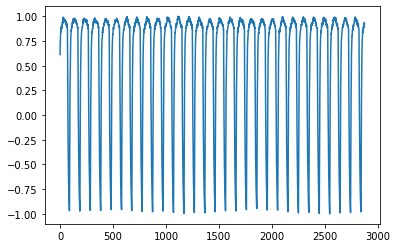

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
df_n.plot(legend=False, ax=ax)
plt.show()

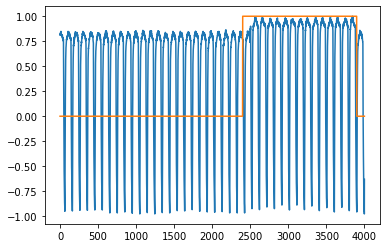

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
anomaly_df.plot(legend=False, ax=ax)
plt.show()

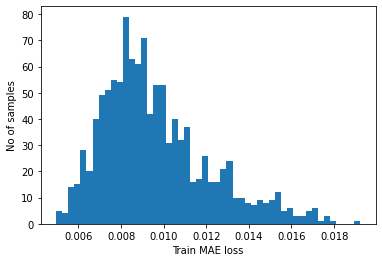

Reconstruction error threshold:  0.019234449565410615


In [ ]:
from matplotlib import pyplot as plt
x_train_pred, losses = predict(model, torch.tensor(train_dataset).float())
train_mae_loss = np.mean(np.abs(np.array(x_train_pred) - np.array(train_dataset)), axis=1)
#train_mae_loss,_ = test(model, torch.tensor(train_dataset).float())
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

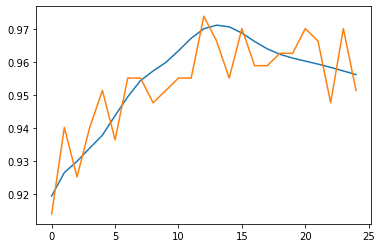

In [ ]:
index=100
plt.plot(x_train_pred[index])
plt.plot(train_dataset[index])
plt.show()

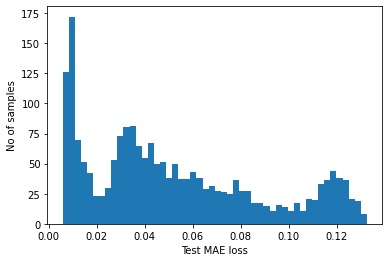

In [ ]:

x_test_pred, losses = predict(model,  torch.tensor(test_anomaly_sequences).float())
test_mae_loss = np.mean(np.abs(np.array(x_test_pred) - np.array(test_anomaly_sequences)), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
#test_mae_loss,_ = test(model, torch.tensor(test_anomaly_dataset).float())
plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

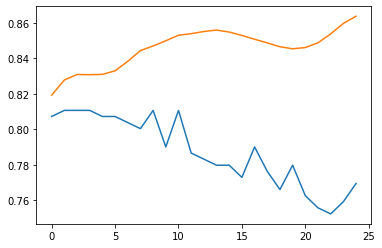

0.810754120349884 0.8637782


In [ ]:
index=10
plt.plot(test_anomaly_sequences[index])
plt.plot(x_test_pred[index])
plt.show()
print(max(test_anomaly_sequences[index]), max(x_test_pred[index]))

In [ ]:
torch.save(model, 'modelA_0515_1.pth')

In [ ]:
modelA_orig = torch.load('modelA.pth')
modelA_orig = modelA_orig.to(device)
# _, total_loss = test(modelA_orig, val_dataset)
# total_loss

In [ ]:
test_anomaly_dataset, _, _ = create_dataset_a(abnormal_data)
publica, _ = test(
  model,
  test_anomaly_dataset
)
len(publica)


4000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


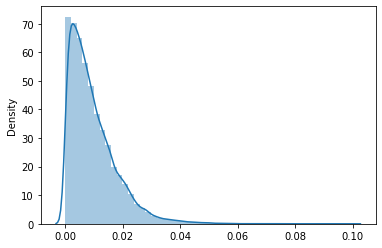

In [ ]:
import seaborn as sns
#_, normal_losses = predict(modelA_orig, train_dataset)
normal_losses, _ = test(model,  torch.tensor(train_dataset).float())
sns.distplot(normal_losses, bins=50, kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


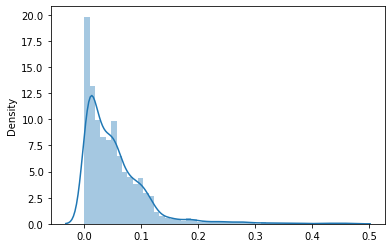

In [ ]:
#_, losses = predict(model, torch.tensor(test_anomaly_sequences).float())
losses, _ = test(model,  test_anomaly_dataset)
sns.distplot(losses, bins=50, kde=True);

In [ ]:
threshold=0.06

In [ ]:
publica_binary =[int(l > threshold) for l in publica]

In [ ]:
publica_binary.count(1)

1292

In [ ]:
import sklearn
sklearn.metrics.roc_auc_score(abnormal_label, publica_binary)

# PrivateA

In [ ]:
anomaly_df = pd.read_csv('sensor_A_private.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_a(abnormal_data)

In [ ]:
privatea, _ = test(
  model,
  test_anomaly_dataset
)
len(privatea)

4000

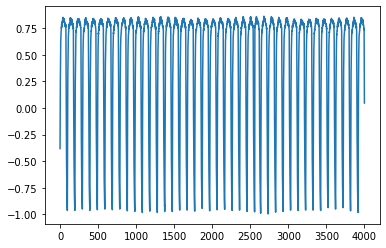

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
anomaly_df.plot(legend=False, ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


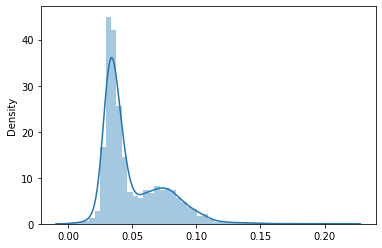

In [ ]:
sns.distplot(privatea, bins=50, kde=True);

# PublicB

In [9]:
from torch import nn, Tensor
class BC_Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(BC_Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.enc1 = nn.Conv1d(in_channels= 1, out_channels =256, kernel_size=101, padding=0, stride=1)
    self.dropout = nn.Dropout(0.2)
    self.enc2 = nn.Conv1d(in_channels= 256,out_channels =128, kernel_size=51, padding=0, stride=1)
    self.enctemp = nn.Conv1d(in_channels= 128,out_channels =128, kernel_size=26, padding=0, stride=1)
    self.fc = nn.Linear(embedding_dim, embedding_dim)
  def forward(self, x):
    x = x.reshape((1, self.n_features, self.seq_len))
    x = self.enc1(x)
    #print('after e1', x.size())
    x = self.dropout(x)
    x = self.enc2(x)
    #print('after e1', x.size())
    x = self.enctemp(x)
    #print('after et', x.size())
    
    return x#hidden_n.reshape((self.n_features, self.embedding_dim))


class BC_Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(BC_Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.fc = nn.Linear(input_dim, input_dim)
    self.dec1 = nn.ConvTranspose1d(in_channels= 128,out_channels =128, kernel_size=26, padding=0, stride=1)
    self.dec2 = nn.ConvTranspose1d(in_channels= 128,out_channels =256, kernel_size=51, padding=0, stride=1)
    self.dec3 = nn.ConvTranspose1d(in_channels= 256,out_channels =1, kernel_size=101, padding=0,)
    self.dropout = nn.Dropout(0.2)
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = self.dec1(x)
    #print('after d1', x.size())
    x = self.dropout(x)
    x = self.dec2(x)
    #print('after d2', x.size())
    x = self.dec3(x)
    #print('after d3', x.size())
    return x#self.output_layer(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class B_Autoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(B_Autoencoder, self).__init__()
    self.seq_len = seq_len
    self.n_features = n_features
    self.encoder = BC_Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = BC_Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    #print('after encoder', x.size())
    x = self.decoder(x)
    return x.reshape((self.seq_len))

In [10]:
def create_sequences_b(df, time_steps=200):
    values = df.astype(np.float32).tolist()
    output = []
    for i in range(0, len(values) - time_steps + 1, 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [11]:
def create_dataset_b(df):
  
  li = df.astype(np.float32).tolist()
  split = list(split_list(li, 200))
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in split]
  if(len(dataset[-1])!=200):
    dataset.pop()
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [12]:
df_n = pd.read_csv('sensor_B_normal.csv')
normal_data = df_n['telemetry'].tolist()
normal_data = np.array(normal_data)
normal_dataset = create_sequences_b(normal_data)
train_dataset, val_dataset = train_test_split(
  normal_dataset,
  test_size=0.1, shuffle=True, random_state = 8
)

In [46]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs, lr = 1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr = 1e-6, verbose = True)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      #print(seq_true.size(), seq_pred.size())
      loss = criterion(seq_pred, seq_true)
      # l1_lambda = 0.05
      # l1_norm = sum(p.abs().sum()
      #               for p in model.parameters())

      # loss = loss + l1_lambda * l1_norm
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      train_losses.append(loss.item())
    
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        # l1_lambda = 0.05
        # l1_norm = sum(p.abs().sum()
        #               for p in model.parameters())

        # loss = loss + l1_lambda * l1_norm
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      print('save')
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
modelB = B_Autoencoder(200, 1, 128)
modelB = modelB.to(device)
modelB, history = train_model(
  modelB,
  torch.tensor(train_dataset).float(),
  torch.tensor(val_dataset).float(),
  n_epochs=200, lr=1e-4
)


save
Epoch 1: train loss 39.05305416162693 val loss 28.2181146393961
save
Epoch 2: train loss 24.689132713032365 val loss 20.004904344900332
save
Epoch 3: train loss 20.758602683212057 val loss 18.94466566683641
save
Epoch 4: train loss 18.677289799394824 val loss 16.546144257730514
save
Epoch 5: train loss 17.248590664060597 val loss 13.85986624546905
save
Epoch 6: train loss 16.181268948576804 val loss 13.27470729244289
save
Epoch 7: train loss 15.316625951977134 val loss 12.49052248428117
save
Epoch 8: train loss 14.457646343366024 val loss 11.924230632497304
save
Epoch 9: train loss 13.827696373953392 val loss 11.657823204994202
save
Epoch 10: train loss 13.28391774627622 val loss 11.048930895862295
save
Epoch 11: train loss 12.738035957035057 val loss 10.686792161927295
save
Epoch 12: train loss 12.400242012404602 val loss 10.077512550709853
save
Epoch 13: train loss 12.06554648663051 val loss 9.977135218791108
save
Epoch 14: train loss 11.75840802737928 val loss 8.970233803364769

In [ ]:
modelB, history = train_model(
  modelB,
  torch.tensor(train_dataset).float(),
  torch.tensor(val_dataset).float(),
  n_epochs=200, lr=5*1e-5
)


In [ ]:
torch.save(modelB, 'modelB_0511.pth')

In [ ]:
modelB_orig = torch.load('modelB.pth')
modelB_orig = modelB_orig.to(device)
# _, loss = test(modelB_orig, val_dataset)
# loss

In [33]:
anomaly_df = pd.read_csv('sensor_B_public.csv')
abnormal_data = anomaly_df['telemary_value'].tolist()
abnormal_label = anomaly_df['label'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset = create_sequences_b(abnormal_data)

In [34]:
test_output_dataset,_, _ = create_dataset_b(abnormal_data)
publicb, _ = test(
  modelB,
  test_output_dataset
)
len(publicb)

4000

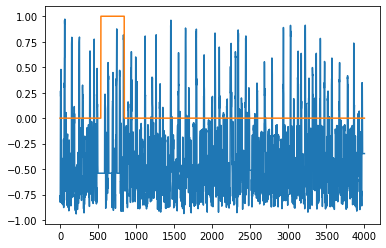

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
anomaly_df.plot(legend=False, ax=ax)
plt.show()

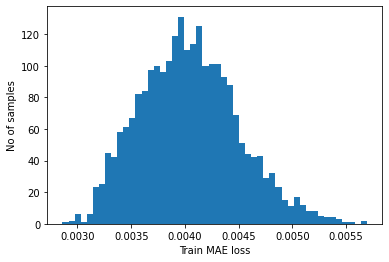

Reconstruction error threshold:  0.0096


In [27]:
from matplotlib import pyplot as plt
x_train_pred, losses = predict(modelB, torch.tensor(train_dataset).float())
train_mae_loss = np.mean(np.abs(np.array(x_train_pred) - np.array(train_dataset)), axis=1)
#train_mae_loss,_ = test(modelB, torch.tensor(train_dataset).float())
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
threshold = 0.0096
print("Reconstruction error threshold: ", threshold)

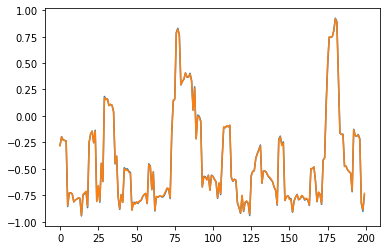

In [28]:
plt.plot(train_dataset[3])
plt.plot(x_train_pred[3])
plt.show()

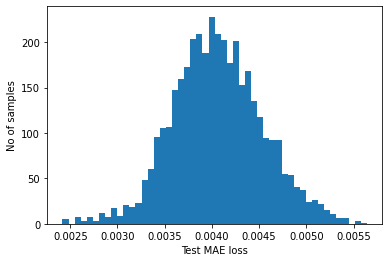

In [29]:

x_test_pred, losses = predict(modelB,  torch.tensor(test_anomaly_dataset).float())
test_mae_loss = np.mean(np.abs(np.array(x_test_pred) - np.array(test_anomaly_dataset)), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
#test_anomaly_dataset = create_sequences_b(abnormal_data)
#test_mae_loss,_ = test(modelB, torch.tensor(test_anomaly_dataset).float())
plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

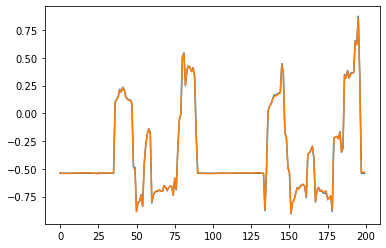

In [41]:
plt.plot(test_anomaly_dataset[550])
plt.plot(x_test_pred[550])
plt.show()

In [ ]:
import sklearn
sklearn.metrics.roc_auc_score(abnormal_label, publicb_binary)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


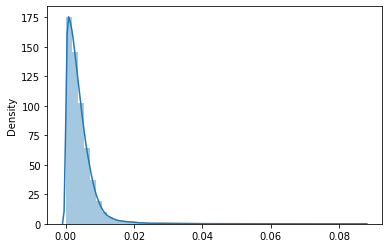

In [31]:
import seaborn as sns
normal_losses, _ = test(modelB, torch.tensor(train_dataset).float())
sns.distplot(normal_losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 0.9

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


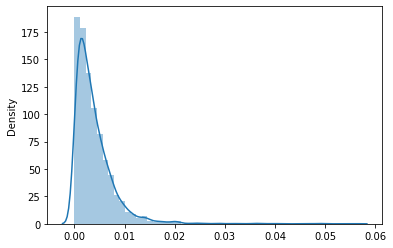

In [35]:
import seaborn as sns
losses, _ = test(modelB, test_output_dataset)
sns.distplot(losses, bins=50, kde=True);

In [42]:
threshold = 0.025

In [43]:
publicb_binary =[int(l > threshold) for l in publicb]

In [44]:
publicb_binary.count(1)

18

In [45]:
import sklearn
sklearn.metrics.roc_auc_score(abnormal_label, publicb_binary)

0.4975622968580715

# PrivateB

In [ ]:
anomaly_df = pd.read_csv('sensor_B_private.csv')
abnormal_data = anomaly_df['telemary_value'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_b(abnormal_data)

In [ ]:
privateb, _ = test(
  modelB_orig,
  test_anomaly_dataset
)
len(privateb)



4000

# PublicC

In [ ]:
def create_dataset_c(df):
  
  li = df.astype(np.float32).tolist()
  split = list(split_list(li, 250))
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in split]
  if(len(dataset[-1])!=250):
    dataset.pop()
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
def create_sequences_c(df, time_steps=250):
    values = df.astype(np.float32).tolist()
    output = []
    for i in range(0, len(values) - time_steps + 1, 2):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
df_n = pd.read_csv('sensor_C_normal.csv')
normal_data = df_n['telemetry'].tolist()
normal_data = np.array(normal_data)
normal_dataset = create_sequences_c(normal_data)
train_dataset, val_dataset = train_test_split(
  normal_dataset,
  test_size=0.15, shuffle=True, random_state=5)

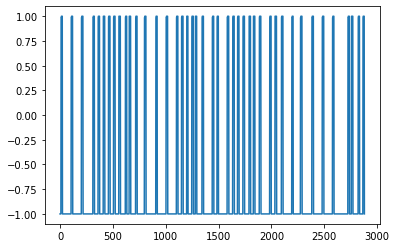

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
df_n.plot(legend=False, ax=ax)
plt.show()

In [ ]:
from torch import nn, Tensor
class CC_Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(CC_Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.enc1 = nn.Conv1d(in_channels= 1, out_channels =128, kernel_size=1, padding=0)
    self.dropout = nn.Dropout(0.2)
    self.enc2 = nn.Conv1d(in_channels= 128,out_channels =64, kernel_size=1, padding=0)
    self.enctemp = nn.Conv1d(in_channels= 64,out_channels =64, kernel_size=1, padding=0)
    self.fc = nn.Linear(embedding_dim, embedding_dim)
  def forward(self, x):
    x = x.reshape((1, self.n_features, self.seq_len))
    x = self.enc1(x)
    #print('after e1', x.size())
    x = self.dropout(x)
    x = self.enc2(x)
    #print('after e2', x.size())
    x = self.enctemp(x)
    x = self.enctemp(x)
    #print('after et', x.size())
    x = self.enctemp(x)
    #print('after et', x.size())
    
    return x#hidden_n.reshape((self.n_features, self.embedding_dim))


class CC_Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(CC_Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.fc = nn.Linear(input_dim, input_dim)
    self.dec1 = nn.ConvTranspose1d(in_channels= 64,out_channels =64, kernel_size=1, padding=0)
    self.dec2 = nn.ConvTranspose1d(in_channels= 64,out_channels =128, kernel_size=1, padding=0)
    self.dec3 = nn.ConvTranspose1d(in_channels= 128,out_channels =1, kernel_size=1, padding=0)
    self.dropout = nn.Dropout(0.2)
    #self.LeakyRelu = nn.functional.leaky_relu(negative_slope=0.01, inplace=False)
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = self.dec1(x)
    #print('after d1', x.size())
    x = self.dec1(x)
    #print('after d1', x.size())
    x = self.dec1(x)
    #print('after d1', x.size())
    x = self.dec1(x)
    #print('after d1', x.size())
    #x = self.dropout(x)
    x = self.dec2(x)
    #print('after d1', x.size())
    x = self.dec3(x)
    #print('after d1', x.size())
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class C_Autoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(C_Autoencoder, self).__init__()
    self.seq_len = seq_len
    self.n_features = n_features
    self.encoder = CC_Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = CC_Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    #print('after encoder', x.size())
    x = self.decoder(x)
    return x.reshape((self.seq_len))

In [ ]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6, verbose=True)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      l1_lambda = 0.05
      l1_norm = sum(p.abs().sum()
                    for p in model.parameters())

      #loss = loss + l1_lambda * l1_norm
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      train_losses.append(loss.item())
    
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        #print(seq_true.size())
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        l1_lambda = 0.05
        l1_norm = sum(p.abs().sum()
                      for p in model.parameters())

        #loss = loss + l1_lambda * l1_norm
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      print('save')
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
modelC = C_Autoencoder(800, 1,4)
modelC = modelC.to(device)
modelC, history = train_model(
  modelC,
  torch.tensor(train_dataset).float(),
  torch.tensor(val_dataset).float(),
  n_epochs=200
)

save
Epoch 1: train loss 38.728909276729254 val loss 14.261576603931985
Epoch 2: train loss 26.11251846589654 val loss 17.83577102612538
save
Epoch 3: train loss 23.86605302888344 val loss 6.875945917360342
save
Epoch 4: train loss 22.761344516978543 val loss 5.758895011464501
save
Epoch 5: train loss 20.713436581969802 val loss 1.4704164107134388
Epoch 6: train loss 20.559554568243243 val loss 2.887329874524645
Epoch 7: train loss 19.58186194152314 val loss 6.645273014238685
Epoch 8: train loss 19.296258886475368 val loss 3.526377875334138
Epoch 9: train loss 19.431205970669225 val loss 8.908986723347075
Epoch 10: train loss 18.514437794145955 val loss 6.38726104141041
Epoch 11: train loss 18.38006079574516 val loss 6.377730336158899
Epoch 12: train loss 17.85933860286868 val loss 5.571009544809913
Epoch 13: train loss 17.684315718137302 val loss 2.420017874164946
Epoch 14: train loss 18.00973229386688 val loss 3.996102293585516
Epoch 15: train loss 17.2581341007716 val loss 11.158050

KeyboardInterrupt: ignored

In [ ]:
torch.save(modelC, 'modelC_0510.pth')

In [ ]:
modelC_orig = torch.load('modelC.pth')
modelC_orig = modelC_orig.to(device)
# _, loss = test(modelC_orig, torch.tensor(val_dataset).float())
# loss

In [ ]:
anomaly_df = pd.read_csv('sensor_C_public.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_label = anomaly_df['label'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_sequences = create_sequences_c(abnormal_data)
test_anomaly_dataset, _, _ = create_dataset_c(abnormal_data)

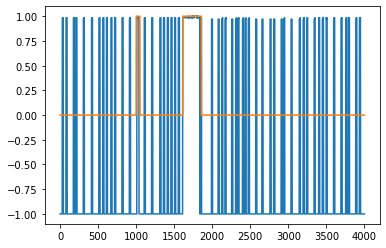

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
anomaly_df.plot(legend=False, ax=ax)
plt.show()

In [ ]:

publicc, _ = test(
  modelC_orig,
  test_anomaly_dataset
)
len(publicc)


4000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


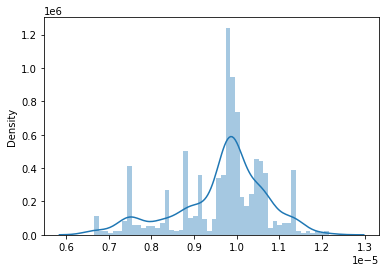

In [ ]:
import seaborn as sns
train_prediction, normal_losses = predict(modelC, torch.tensor(train_dataset).float())
sns.distplot(normal_losses, bins=50, kde=True);

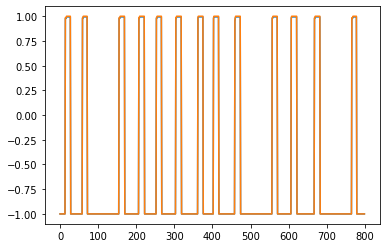

In [ ]:
from matplotlib import pyplot as plt
index = 0
plt.plot(train_prediction[index])
plt.plot(train_dataset[index])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


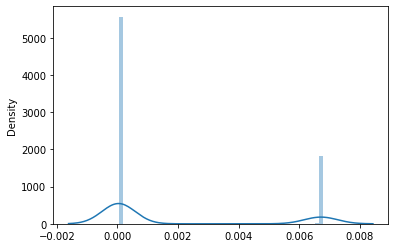

In [ ]:
import seaborn as sns
test_prediction, losses = predict(modelC, test_anomaly_dataset)
loss, _ = test(modelC, test_anomaly_dataset)
sns.distplot(loss, bins=50, kde=True);

In [ ]:
len(test_prediction)

5

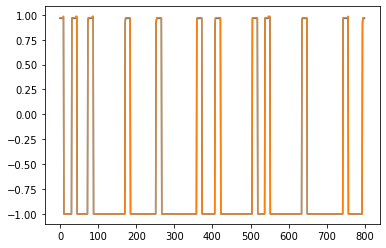

In [ ]:
from matplotlib import pyplot as plt
index = 3
plt.plot(test_prediction[index])
plt.plot(test_anomaly_dataset[index])
plt.show()

In [ ]:
THRESHOLD = 0.002

In [ ]:
publicc_binary =[l > THRESHOLD for l in publicc]

In [ ]:
publicc_binary.count(1)

996

In [ ]:
import sklearn
sklearn.metrics.roc_auc_score(abnormal_label, publicc_binary)

0.8480970877898193

# PrivateC

In [ ]:
anomaly_df = pd.read_csv('sensor_C_private.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_c(abnormal_data)

In [ ]:
privatec, _ = test(
  modelC_orig,
  test_anomaly_dataset
)
len(privatec)

4000

# PublicD

In [ ]:
def create_dataset_d(df):
  
  li = df.astype(np.float32).tolist()
  split = list(split_list(li, 100))
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in split]
  if(len(dataset[-1])!=100):
    dataset.pop()
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
def create_sequences_d(df, time_steps=100):
    values = df.astype(np.float32).tolist()
    output = []
    for i in range(0, len(values) - time_steps + 1, 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
df_n = pd.read_csv('sensor_D_normal.csv')
normal_data = df_n['telemetry'].tolist()
normal_data = np.array(normal_data)
normal_dataset = create_sequences_d(normal_data)
train_dataset, val_dataset = train_test_split(
  normal_dataset,
  test_size=0.15, shuffle=True, random_state=8
)

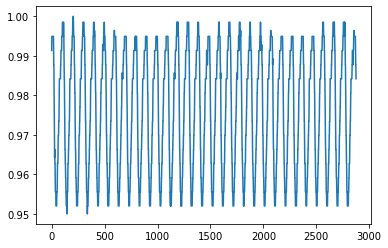

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
df_n.plot(legend=False, ax=ax)
plt.show()

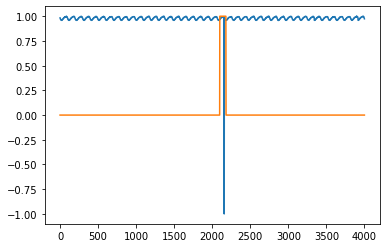

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
anomaly_df.plot(legend=False, ax=ax)
plt.show()

In [ ]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr = 1e-6, verbose=True)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      l1_lambda = 0.05
      
      l1_norm = sum(p.abs().sum()
                    for p in model.parameters())

      #loss = loss + l1_lambda * l1_norm
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      train_losses.append(loss.item())
    
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        #print(seq_true.size())
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        l1_lambda = 0.05
        l1_norm = sum(p.abs().sum()
                      for p in model.parameters())

        #loss = loss + l1_lambda * l1_norm
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      print('save')
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
modelD = Autoencoder(100, 1, 4)
modelD = modelD.to(device)
modelD, history = train_model(
  modelD,
  torch.tensor(train_dataset).float(),
  torch.tensor(val_dataset).float(),
  n_epochs=150
)
# _, loss = test(modelD, val_dataset)
# loss

save
Epoch 1: train loss 1.7887334382887614 val loss 0.3781915464275461
save
Epoch 2: train loss 0.5639946363234924 val loss 0.29009420108452116
Epoch 3: train loss 0.4707166258308847 val loss 0.34700990595120035
save
Epoch 4: train loss 0.4042228410557165 val loss 0.28636829730132213
save
Epoch 5: train loss 0.3438981084247767 val loss 0.2536872163665094
save
Epoch 6: train loss 0.3239684911855197 val loss 0.23369885048420308
Epoch 7: train loss 0.3162982550212892 val loss 0.2628590408846629
Epoch 8: train loss 0.3009644866999933 val loss 0.31697651765329377
save
Epoch 9: train loss 0.2972650273624113 val loss 0.19061293862134718
Epoch 10: train loss 0.28788964970637176 val loss 0.2490402418646595
Epoch 11: train loss 0.2795212917661263 val loss 0.209593149826681
save
Epoch 12: train loss 0.2767670954435559 val loss 0.14584540849109348
Epoch 13: train loss 0.27814713549816 val loss 0.14934995048623576
Epoch 14: train loss 0.27038060803029496 val loss 0.24967839134682854
save
Epoch 15:

In [ ]:
_, loss= test(modelD, torch.tensor(val_dataset).float())
loss

1.38768771162136

In [ ]:
torch.save(modelD, 'modelD_0514_1.pth')

In [ ]:
modelD_orig = torch.load('modelD.pth')
modelD_orig = modelD_orig.to(device)
# _, loss= test(modelD_orig, val_dataset)
# loss

In [ ]:
anomaly_df = pd.read_csv('sensor_D_public.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_label = anomaly_df['label'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_d(abnormal_data)

In [ ]:
publicd, _ = test(
  modelD_orig,
  test_anomaly_dataset
)
len(publicd)


4000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


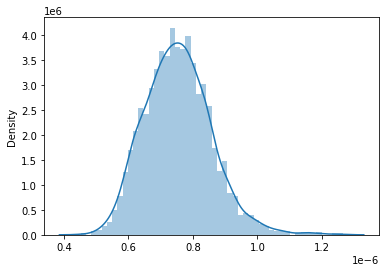

In [ ]:
import seaborn as sns
train_prediction, normal_losses = predict(modelD, torch.tensor(train_dataset).float())
sns.distplot(normal_losses, bins=50, kde=True);

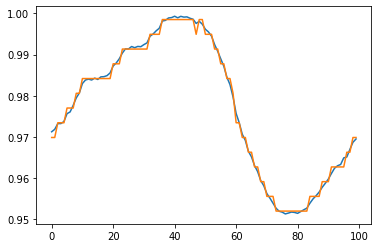

In [ ]:
from matplotlib import pyplot as plt
index = 200
plt.plot(train_prediction[index])
plt.plot(train_dataset[index])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


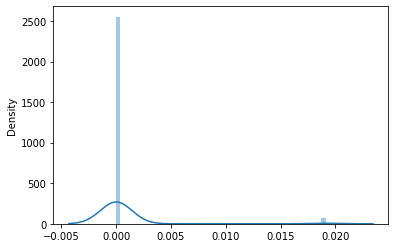

In [ ]:
import seaborn as sns
test_prediction, losses = predict(modelD, test_anomaly_dataset)
sns.distplot(losses, bins=50, kde=True);

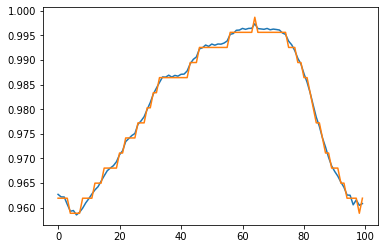

In [ ]:
from matplotlib import pyplot as plt
index = 10
plt.plot(test_prediction[index])
plt.plot(test_anomaly_dataset[index])
plt.show()

In [ ]:
THRESHOLD = 0.005#max(normal_losses)

In [ ]:
publicd_binary =[int(l > THRESHOLD) for l in publicd]

In [ ]:
publicd_binary.count(1)

37

In [ ]:
import sklearn
sklearn.metrics.roc_auc_score(abnormal_label, publicd_binary)

0.6944838705661176

# PrivateD

In [ ]:
anomaly_df = pd.read_csv('sensor_D_private.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_d(abnormal_data)

In [ ]:
privated, _ = test(
  modelD_orig,
  test_anomaly_dataset
)
len(privated)

4000

# PublicE

In [ ]:
def create_dataset_e(df):
  
  li = df.astype(np.float32).tolist()
  split = list(split_list(li, 200))
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in split]
  if(len(dataset[-1])!=200):
    dataset.pop()
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
def create_sequences_e(df, time_steps=200):
    values = df.astype(np.float32).tolist()
    output = []
    for i in range(0, len(values) - time_steps + 1, 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
df_n = pd.read_csv('sensor_E_normal.csv')
normal_data = df_n['telemetry'].tolist()
normal_data = np.array(normal_data)
normal_dataset = create_sequences_e(normal_data)

In [ ]:

train_dataset, val_dataset = train_test_split(
  normal_dataset,
  test_size=0.2, shuffle=True, random_state = 4
)
print(train_dataset.shape, val_dataset.shape)

(1797, 200) (450, 200)


In [ ]:
import copy
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr = 1e-6, verbose = True)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred.reshape((-1)), seq_true.reshape((-1)))
      l1_lambda = 0.05
      l1_norm = sum(p.abs().sum()
                    for p in model.parameters())

      #loss = loss + l1_lambda * l1_norm
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()
      train_losses.append(loss.item())
    
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        #print(seq_true.size())
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred.reshape((-1)), seq_true.reshape((-1)))
        l1_lambda = 0.05
        l1_norm = sum(p.abs().sum()
                      for p in model.parameters())

        #loss = loss + l1_lambda * l1_norm
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss:
      print('save')
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
modelE = Autoencoder(200, 1, 4)
modelE = modelE.to(device)
modelE, history = train_model(
  modelE,
  torch.tensor(train_dataset).float(),
  torch.tensor(val_dataset).float(),
  n_epochs=150
)
_, loss= test(modelE, val_dataset)
loss

In [ ]:
torch.save(modelE, 'modelE_0514.pth')

In [ ]:
modelE_orig = torch.load('modelE.pth')
modelE_orig = modelE_orig.to(device)
_, loss= test(modelE_orig, torch.tensor(val_dataset).float())
loss

3.335043674574958

In [ ]:
anomaly_df = pd.read_csv('sensor_E_public.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_label = anomaly_df['label'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_e(abnormal_data)

In [ ]:
publice, _ = test(
  modelE_orig,
  test_anomaly_dataset
)
len(publice)


4000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


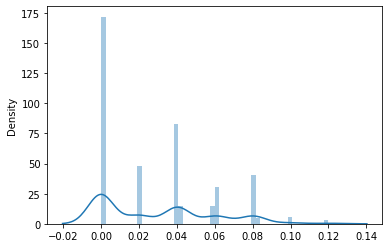

In [ ]:
import seaborn as sns
_, normal_losses = predict(modelE, torch.tensor(train_dataset).float())
sns.distplot(normal_losses, bins=50, kde=True);

In [ ]:
THRESHOLD = max(normal_losses)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


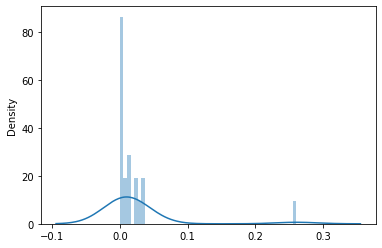

In [ ]:
_, losses = predict(modelE, test_anomaly_dataset)
sns.distplot(losses, bins=50, kde=True);

In [ ]:
publice_binary =[int(l > THRESHOLD) for l in publice]

In [ ]:
import sklearn
sklearn.metrics.roc_auc_score(abnormal_label, publice_binary)
#best 0.6814102564102564

0.6864102564102564

# PrivateE

In [ ]:
anomaly_df = pd.read_csv('sensor_E_private.csv')
abnormal_data = anomaly_df['telemetry'].tolist()
abnormal_data = np.array(abnormal_data)

test_anomaly_dataset, _, _ = create_dataset_e(abnormal_data)

In [ ]:
privatee, _ = test(
  modelE_orig,
  test_anomaly_dataset
)
len(privatee)

4000

# Save model

In [ ]:
id = 0
with open('output.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['id', 'pred'])
  for c in publica:
    writer.writerow([str(id), str(c)])
    id+=1
    
  for c in publicb:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in publicc:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in publicd:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in publice:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in privatea:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in privateb:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in privatec:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in privated:
    writer.writerow([str(id), str(c)])
    id+=1
  for c in privatee:
    writer.writerow([str(id), str(c)])
    id+=1